# Joint TV for mutiple PET/SPECT images
This demonstration shows how to do a synergistic reconstruction of two PET images. Both PET images show the same underlying anatomy but of course with different tracer distribution. In order to make use of this similarity a joint total variation (TV) operator is used as a regularisation in an iterative image reconstruction approach. 

This demo is a jupyter notebook, i.e. intended to be run step by step.
You could export it as a Python file and run it one go, but that might
make little sense as the figures are not labelled.


First Authors: Christoph Kolbitsch, Evangelos Papoutsellis, Edoardo Pasca  
Updated for PET/SPECT: Sam Porter \
First version: 16th of June 2021  
Updated: 26nd of June 2021  
Updated for PET/SPECT: 31st of March 2022

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2021 Rutherford Appleton Laboratory STFC.    
Copyright 2021 Physikalisch-Technische Bundesanstalt.  

This is software developed for the Collaborative Computational
Project in Positron Emission Tomography and Magnetic Resonance imaging
(http://www.ccppetmr.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Initial set-up

In [38]:
# Make sure figures appears inline
%matplotlib notebook

In [39]:
# Make sure everything is installed that we need
!pip install brainweb nibabel --user
!pip install ipython --user

In [40]:
# Initial imports etc
import numpy
from numpy.linalg import norm
import matplotlib.pyplot as plt
from matplotlib import animation
import random

import os
import sys
import shutil
import brainweb
from tqdm.auto import tqdm
import glob

# Import SIRF functionality
import notebook_setup
import sirf.Gadgetron as mr
from sirf_exercises import exercises_data_path
import sirf.STIR as STIR
import plotly.io as pio


# Import CIL functionality
from cil.framework import  AcquisitionGeometry, BlockDataContainer, BlockGeometry, ImageGeometry
from cil.optimisation.functions import Function, OperatorCompositionFunction, SmoothMixedL21Norm, L1Norm, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation, LeastSquares, ZeroFunction, KullbackLeibler
from cil.optimisation.operators import GradientOperator, BlockOperator, ZeroOperator, CompositionOperator, LinearOperator, FiniteDifferenceOperator, Operator
from cil.optimisation.algorithms import PDHG, FISTA, GD
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from IPython.display import HTML

msg = STIR.MessageRedirector('info.txt', 'warn.txt', 'errr.txt')

%matplotlib inline

# Utilities

In [41]:
# First define some handy function definitions
# To make subsequent code cleaner, we have a few functions here. You can ignore
# ignore them when you first see this demo.

def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink = 0.3)
    plt.title(title)
    plt.axis("off")

def crop_and_fill(templ_im, vol):
    """Crop volumetric image data and replace image content in template image object"""
    # Get size of template image and crop
    idim_orig = templ_im.as_array().shape
    idim = (1,)*(3-len(idim_orig)) + idim_orig
    offset = (numpy.array(vol.shape) - numpy.array(idim)) // 2
    vol = vol[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1], offset[2]:offset[2]+idim[2]]
    
    # Make a copy of the template to ensure we do not overwrite it
    templ_im_out = templ_im.copy()
    
    # Fill image content 
    templ_im_out.fill(numpy.reshape(vol, idim_orig))
    return(templ_im_out)

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = STIR.TruncateToCylinderProcessor()
    filter.apply(image)
    return image

### Joint TV reconstruction of two PET/SPECT images

Assume we want to reconstruct two PET\SPECT images $u$ and $v$ and utilse the similarity between both images using a joint TV ($JTV$) operator we can formulate the reconstruction problem as:

$$
\begin{equation}
(u^{*}, v^{*}) \in \underset{u,v}{\operatorname{argmin}}\biggl \{ \mathcal{D}\bigl(A_1u,g_1) +  \mathcal{D}\bigl(A_2v,g_2) + \alpha\,\mathrm{JTV}_{\eta, \lambda}(u, v) \biggl \}
\end{equation}
$$


* $\mathcal{D}\bigl(Ax,g)$ `Data Fidelity Term` - we'll use the Kullbach Liebler divergence:
$$ \mathcal{D}(g|Ax) = \sum_i \log g_i\frac{g_i}{(Ax)_i} $$
* $JTV_{\eta, \lambda}(u, v) = \sum \sqrt{ \lambda|\nabla u|^{2} + (1-\lambda)|\nabla v|^{2} + \eta^{2}}$
* $A_{1}$, $A_{2}$: __PET/SPECT__ `AcquisitionModel`
* $g_{1}$, $g_{2}$: __PET/SPECT__ `AcquisitionData`


### Solving this problem 

In order to solve the above minimization problem, we will use an alternating minimisation approach, where one variable is fixed and we solve wrt to the other variable:

$$
\begin{align*}
u^{k+1} & = \underset{u}{\operatorname{argmin}} \biggl \{ \mathcal{D}_{KL}\bigl(A_1u,g_1) + \alpha_{1}\,\mathrm{JTV}_{\eta, \lambda}(u, v^{k}) \biggl \} \quad \text{subproblem 1}\\
v^{k+1} & = \underset{v}{\operatorname{argmin}} \biggl \{ \mathcal{D}_{KL}\bigl(A_2v,g_2) + \alpha_{2}\,\mathrm{JTV}_{\eta, 1-\lambda}(u^{k+1}, v) \biggl \} \quad \text{subproblem 2}\\
\end{align*}$$

We are going to use a gradient descent approach to solve each of these subproblems alternatingly.

The *regularisation parameter* `alpha` should be different for each subproblem. But not to worry at this stage. Maybe we should use $\alpha_{1}, \alpha_{2}$ in front of the two JTVs and a $\lambda$, $1-\lambda$ for the first JTV and $1-\lambda$, $\lambda$, for the second JTV with $0<\lambda<1$.


This notebook builds on several other notebooks and hence certain steps will be carried out with minimal documentation. If you want more explainations, then we would like to ask you to refer to the corresponding notebooks which are mentioned in the following list. The steps we are going to carry out are

  - (A) Get an FDG and amyloid PET image from brainweb which we are going to use as ground truth $u_{gt}$ and $v_{gt}$ for our reconstruction (further information: `introduction` notebook)
  
  - (B) Create __PET/SPECT__ `AcquisitionModel` $A_{1}$ and $A_{2}$ (further information: `acquisition_model_mr_pet_ct` notebook)
  
  - (C) Set up the joint TV reconstruction problem
  
  - (D) Solve the joint TV reconstruction problem (further information on gradient descent: `gradient_descent_mr_pet_ct` notebook)

# (A) Get brainweb data

We will download and use data from the brainweb.

In [42]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

In [43]:
for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)
    vol_amyl = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1, PetClass=brainweb.Amyloid)

mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  2.06subject/s]


In [44]:
uMap_arr = vol['uMap']
amyl_arr = vol_amyl['PET']
fdg_arr = vol['PET']

# Reduce values in uMamp to make more realistic
uMap_arr /= numpy.max(uMap_arr)*10

# Normalise fdg and amyloid images
fdg_arr /= numpy.max(fdg_arr)
amyl_arr /= numpy.max(amyl_arr)

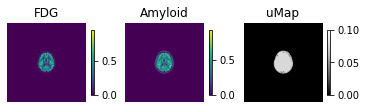

In [45]:
# Display it
plt.figure();
slice_show = fdg_arr.shape[0]//2
plot_2d_image([1,3,1], fdg_arr[slice_show, :, :], 'FDG')
plot_2d_image([1,3,2], amyl_arr[slice_show, :, :], 'Amyloid')
plot_2d_image([1,3,3], uMap_arr[slice_show, :, :], 'uMap', cmap="Greys_r")

Ok, we got to two images with FDG and Amyloid tracer distribution BUT they brain looks a bit small. Spoiler alert: We are going to reconstruct images with a FOV 256 x 256 voxels. As the above image covers 344 x 344 voxels, the brain would only cover a small part of our FOV. In order to ensure the brain fits well into our FOV, we are going to scale the images.

In order to do this we are going to use an image `rescale` from the skimage package and simply rescale the image by a factor 2 and then crop it. To speed things up, we are going to already select a single slice because also our MR scan is going to be 2D.

In [46]:
from skimage.transform import rescale

# Select central slice
central_slice = fdg_arr.shape[0]//2
fdg_arr = fdg_arr[central_slice, :, :]
amyl_arr = amyl_arr[central_slice, :, :]
uMap_arr = uMap_arr[central_slice, :, :]

# Rescale by a factor 2.0
fdg_arr = rescale(fdg_arr, 2,0)
amyl_arr = rescale(amyl_arr, 2.0)
uMap_arr = rescale(uMap_arr, 2.0)

# Select a central ROI with 256 x 256 
# We could also skip this because it is automaticall done by crop_and_fill() 
# but we would like to check if we did the right thing
idim = [256, 256]
offset = (numpy.array(fdg_arr.shape) - numpy.array(idim)) // 2
fdg_arr = fdg_arr[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1]]
amyl_arr = amyl_arr[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1]]
uMap_arr = uMap_arr[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1]]

# Now we make sure our image is of shape (1, 256, 256) again because in __SIRF__ even 2D images 
# are expected to have 3 dimensions.
fdg_arr = fdg_arr[numpy.newaxis,...]
amyl_arr = amyl_arr[numpy.newaxis,...]
uMap_arr = uMap_arr[numpy.newaxis,...]

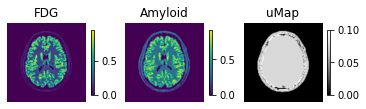

In [47]:
# Display it
plt.figure();
slice_show = fdg_arr.shape[0]//2
plot_2d_image([1,3,1], fdg_arr[0,:,:], 'FDG')
plot_2d_image([1,3,2], amyl_arr[0,:,:], 'Amyloid',)
plot_2d_image([1,3,3], uMap_arr[0,:,:], 'uMap', cmap="Greys_r")

In [48]:
sino = STIR.AcquisitionData('data/PET/template_sinogram.hs')
dim = fdg_arr.shape
im = STIR.ImageData(sino)
voxel_size=im.voxel_sizes()
im.initialise(dim,voxel_size)
fdg = crop_and_fill(im, fdg_arr)
amyl = crop_and_fill(im, amyl_arr)
uMap = crop_and_fill(im, uMap_arr)

Now, that looks better. Now we have got images we can use for our simulation.

# (B) Simulate noisy AcquisitionData

In [49]:
def get_acquisition_model(uMap, templ_sino, detector_efficiency = 1, attenuation = True, itype = 'PET'):
    """ Function to create PET/SPECT acquisition model """
    if itype == 'PET':
        am = STIR.AcquisitionModelUsingRayTracingMatrix()
        # Set up sensitivity due to attenuation
        am.set_num_tangential_LORs(5)
        if attenuation is True:
            asm_attn = STIR.AcquisitionSensitivityModel(uMap, am)
            asm_attn.set_up(templ_sino)
            bin_eff = templ_sino.get_uniform_copy(detector_efficiency)
            print('applying attenuation (please wait, may take a while)...')
            asm_attn.unnormalise(bin_eff)
            asm = STIR.AcquisitionSensitivityModel(bin_eff)
            am.set_acquisition_sensitivity(asm)
    elif itype == 'SPECT':
        acq_model_matrix = STIR.SPECTUBMatrix()
        acq_model_matrix.set_resolution_model(0,0,full_3D=False)
        print("False")
        if attenuation is True:
            acq_model_matrix.set_attenuation_image(uMap)
        am = STIR.AcquisitionModelUsingMatrix(acq_model_matrix)
        
    else:
        raise Exception('Please ensure type = "PET" or "SPECT"')
    am.set_up(templ_sino, uMap)
    return am


In [50]:
def add_noise(proj_data,noise_factor = 0.01):  
    """ Function to add noise to PET/SPECT Acquistion Data """
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    proj_data_arr = numpy.abs(proj_data_arr)
    noisy_proj_data_arr = numpy.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr);
    return noisy_proj_data*noise_factor

Next we are going to create the two __MR__ `AcquisitionModel` $A_{1}$ and $A_{2}$ 

In [51]:
acq_model = get_acquisition_model(uMap, sino)
anorm = acq_model.norm() #norm of the operator to avoid any scaling

applying attenuation (please wait, may take a while)...
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting...ok
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting...ok
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting...ok


and simulate `AcquisitionData` $g_{1}$ and $g_{2}$ 

no additive term added
applying unnormalisation...ok
no background term added
no additive term added
applying unnormalisation...ok
no background term added
You may need to close Figure 1 window to continue...


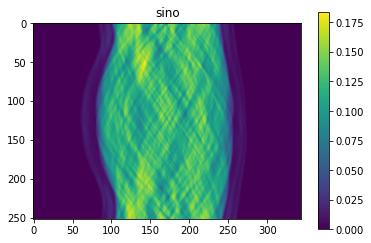

In [52]:
# Forward project our images into data space
data_fdg = acq_model.forward(fdg)/anorm
data_amyl = acq_model.forward(amyl)/anorm
c_slice = data_fdg.shape[1]//2 # central slice
STIR.show_2D_array("sino",data_fdg.as_array()[0,c_slice,:,:])

Lastly we are going to add some noise

You may need to close Figure 1 window to continue...


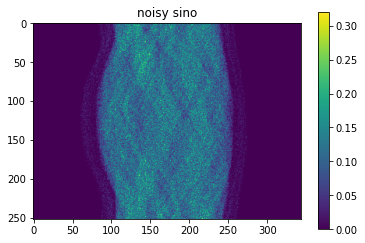

In [53]:
# Add noise
noisy_data_fdg = add_noise(data_fdg)
noisy_data_amyl = add_noise(data_amyl)
STIR.show_2D_array("noisy sino",noisy_data_fdg.as_array()[0,c_slice,:,:])

Just to check we are going to apply the backward/adjoint operation to do a simply image reconstruction.

In [54]:
# Simple reconstruction
u_simple = acq_model.backward(noisy_data_fdg)/anorm
v_simple = acq_model.backward(noisy_data_amyl)/anorm

applying unnormalisation...ok
backprojecting...ok
applying unnormalisation...ok
backprojecting...ok


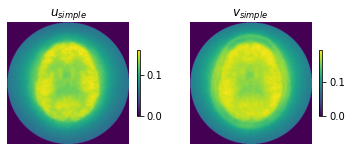

In [55]:
# Display it
plt.figure();
plot_2d_image([1,2,1], numpy.abs(u_simple.as_array())[0, :, :], '$u_{simple}$')
plot_2d_image([1,2,2], numpy.abs(v_simple.as_array())[0, :, :], '$v_{simple}$')

These images look quite poor compared to the ground truth input images, because they are reconstructed by a simple back-projection.

# (C) Set up the joint TV reconstruction problem

So far we have used mainly __SIRF__ functionality, now we are going to use __CIL__ in order to set up the reconstruction problem and then solve it. In order to be able to reconstruct both $u$ and $v$ at the same time, we will make use of `BlockDataContainer`. In the following we will define an operator which allows us to project a $(u,v)$ `BlockDataContainer` object into either $u$ or $v$. In literature, this operator is called **[Projection Map (or Canonical Projection)](https://proofwiki.org/wiki/Definition:Projection_(Mapping_Theory))** and is defined as:

$$ \pi_{i}: X_{1}\times\cdots\times X_{n}\rightarrow X_{i}$$

with

$$\pi_{i}(x_{0},\dots,x_{i},\dots,x_{n}) = x_{i},$$

mapping an element $x$ from a Cartesian Product $X =\prod_{k=1}^{n}X_{k}$ to the corresponding element $x_{i}$ determined by the index $i$.

In [56]:
class ProjectionMap(LinearOperator):
    
    def __init__(self, domain_geometry, index, range_geometry=None):
        
        self.index = index
        if range_geometry is None:
            range_geometry = domain_geometry.geometries[self.index]
            
        super(ProjectionMap, self).__init__(domain_geometry=domain_geometry, 
                                           range_geometry=range_geometry)   
        
    def direct(self,x,out=None):
                        
        if out is None:
            return x[self.index]
        else:
            out.fill(x[self.index])
    
    def adjoint(self,x, out=None):
        
        if out is None:
            tmp = self.domain_geometry().allocate()
            tmp[self.index].fill(x)            
            return tmp
        else:
            out[self.index].fill(x) 
  

In the following we define the `SmoothJointTV` class. Our plan is to use the Gradient descent (`GD`) algorithm to solve the above problems. This implements the `__call__` method required to monitor the objective value and the `gradient` method that evaluates the gradient of `JTV`.

For the two subproblems, the first variations with respect to $u$ and $v$ variables are:

$$
\begin{equation}
\begin{aligned}
& \biggl(1-\frac{g_{1}}{A_{1}u+\eta}\biggl) - \alpha_{1} \mathrm{div}\bigg( \frac{\nabla u}{|\nabla(u, v)|_{2,\eta,\lambda}}\bigg)\\
& \biggl(1-\frac{g_{2}}{A_{2}v+\eta}\biggl) - \alpha_{2} \mathrm{div}\bigg( \frac{\nabla v}{|\nabla(u, v)|_{2,\eta,1-\lambda}}\bigg)
\end{aligned}
\end{equation}
$$

where $$|\nabla(u, v)|_{2,\eta,\lambda} = \sqrt{ \lambda|\nabla u|^{2} + (1-\lambda)|\nabla v|^{2} + \eta^{2}}.$$

and $ \eta $ means we can avoid dividing by zero


In [57]:
class SmoothJointTV(Function):
              
    def __init__(self, eta, axis, lambda_par, domain_geometry):
                
        r'''
        :param eta: smoothing parameter making SmoothJointTV differentiable 
        '''

        super(SmoothJointTV, self).__init__(L=8)
        
        # smoothing parameter
        self.eta = eta   
        
        # GradientOperator
        self.grad = GradientOperator(domain_geometry)
                
        # Which variable to differentiate
        self.axis = axis
        
        if self.eta==0:
            raise ValueError('Need positive value for eta')
            
        self.lambda_par=lambda_par    
                                    
                            
    def __call__(self, x):
        
        r""" x is BlockDataContainer that contains (u,v). Actually x is a BlockDataContainer that contains 2 BDC.
        """
        if not isinstance(x, BlockDataContainer):
            raise ValueError('__call__ expected BlockDataContainer, got {}'.format(type(x))) 

        tmp = numpy.abs((self.lambda_par*self.grad.direct(x[0]).pnorm(2).power(2) + (1-self.lambda_par)*self.grad.direct(x[1]).pnorm(2).power(2)+\
              self.eta**2).sqrt().sum())

        return tmp    
                        
             
    def gradient(self, x, out=None):
        
        denom = (self.lambda_par*self.grad.direct(x[0]).pnorm(2).power(2) + (1-self.lambda_par)*self.grad.direct(x[1]).pnorm(2).power(2)+\
              self.eta**2).sqrt()         
        
        if self.axis==0:            
            num = self.lambda_par*self.grad.direct(x[0])                        
        else:            
            num = (1-self.lambda_par)*self.grad.direct(x[1])            

        if out is None:    
            tmp = self.grad.range.allocate()
            tmp[self.axis].fill(self.grad.adjoint(num.divide(denom)))
            return tmp
        else:                                
            self.grad.adjoint(num.divide(denom), out=out[self.axis])

Lastly we create a normalisation operator class in order to avoid any multiplicative factors in our acquisiton model operator

In [58]:
class Norm(LinearOperator):

    def __init__(self, norm, domain_geometry):

        self.norm = norm

        super(Norm, self).__init__(domain_geometry=domain_geometry, 
                                           range_geometry=domain_geometry)   

    def direct(self,x,out=None):
        if out is None:
            return x/self.norm
        else:
            out.fill(x/self.norm)

    def adjoint(self,x,out=None):
        if out is None:
            return x/self.norm
        else:
            out.fill(x/self.norm)

We now slightly alter the gradient descent `update` method in order to enforce positivity. This update projects our image onto the set of positive numbers and modifies our algorithm slightly to something known as the Gradient Projection algorithm.

In [59]:
def updateGD(self):
        '''Single iteration of Gradient Descent'''
        
        self.objective_function.gradient(self.x, out=self.x_update)
        self.x_update *= -self.step_size
        self.x += self.x_update

        # remove any negative values
        self.x += self.x.abs() ##update
        self.x /= 2            ##update
    
GD.update = updateGD    

Now we are going to put everything together and define our two objective functions which solve the two subproblems which we defined at the beginning

In [60]:
# Parameters
alpha1 = 0.05
alpha2 = 0.05
lambda_par = 0.5
eta = 1e-12
eta_sino = sino.get_uniform_copy(eta) # uniform sino for KL diveregence smoothing

# BlockGeometry for the two modalities
bg = BlockGeometry(u_simple, v_simple)

# Projection map, depending on the unkwown variable
L1 = ProjectionMap(bg, index=0)
L2 = ProjectionMap(bg, index=1)

# normalisation operator
normalise = Norm(anorm, noisy_data_fdg)

# Fidelity terms based on the acqusition data
f1 = KullbackLeibler(b=noisy_data_fdg, eta=eta_sino)
f2 = KullbackLeibler(b=noisy_data_amyl, eta=eta_sino)

# JTV for each of the subproblems
JTV1 = alpha1*SmoothJointTV(eta=eta, axis=0, lambda_par = lambda_par , domain_geometry = uMap)
JTV2 = alpha2*SmoothJointTV(eta=eta, axis=1, lambda_par = 1-lambda_par, domain_geometry = uMap)

# Compose the two objective functions
op1 = CompositionOperator(normalise, acq_model, L1)
op2 = CompositionOperator(normalise, acq_model, L2)
objective1 = OperatorCompositionFunction(f1 , op1) + JTV1
objective2 = OperatorCompositionFunction(f2 , op2) + JTV2

Initialised GradientOperator with C backend running with  8  threads
Initialised GradientOperator with C backend running with  8  threads


# (D) Solve the joint TV reconstruction problem

In [61]:
# We start with a cylindrical uniform image
init = make_cylindrical_FOV(fdg.get_uniform_copy(1))
x0 = BlockDataContainer(init,init)

step = 0.1

# We are also going to log the value of the objective functions
obj1_val_it = []
obj2_val_it = []
# and the images
images = []

for i in range(4):
    images.append(x0.copy())

    gd1 = GD(x0, objective1, step_size=step, \
          max_iteration = 4, update_objective_interval = 1)
    gd1.run(verbose=1)
    
    # We skip the first one because it gets repeated
    obj1_val_it.extend(gd1.objective[1:])
    
    # Here we are going to do a little "trick" in order to better see, when each subproblem is optimised, we
    # are going to append NaNs to the objective function which is currently not optimised. The NaNs will not
    # show up in the final plot and hence we can nicely see each subproblem.
    obj2_val_it.extend(numpy.ones_like(gd1.objective[1:])*numpy.nan)
    
    gd2 = GD(gd1.solution, objective2, step_size=step, \
          max_iteration = 4, update_objective_interval = 1)
    gd2.run(verbose=1)
    
    obj2_val_it.extend(gd2.objective[1:])
    obj1_val_it.extend(numpy.ones_like(gd2.objective[1:])*numpy.nan)
    
    x0.fill(gd2.solution)
    
    print('* * * * * * Outer Iteration ', i, ' * * * * * *\n')

images.append(x0.copy())
print('* * * * * * Reconstruction Complete * * * * * *\n')

GD setting up
no additive term added
applying unnormalisation...ok
no background term added
GD configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
no additive term added
applying unnormalisation...ok
no background term added
        0          4         0.000          5.69332e+04
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting...ok
no additive term added
applying unnormalisation...ok
no background term added
        1          4         5.410          4.60155e+04
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting...ok
no additive term added
applying unnormalisation...ok
no background term added
        2          4         5.406          3.54747e+04
no additive term added
applying unnormalisation...ok
no background term added
applying unnormalisation...ok
backprojecting..

Finally we can look at the images $u_{jtv}$ and $v_{jtv}$ and compare them to the simple reconstruction $u_{simple}$ and $v_{simple}$ and the original ground truth images.

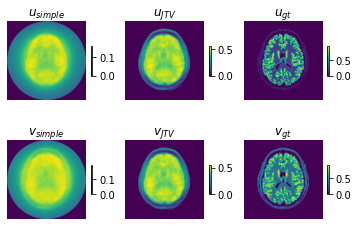

In [66]:
u_jtv = numpy.squeeze(numpy.abs(x0[0].as_array()))
v_jtv = numpy.squeeze(numpy.abs(x0[1].as_array()))

plt.figure()
plot_2d_image([2,3,1], numpy.squeeze(numpy.abs(u_simple.as_array())), '$u_{simple}$')
plot_2d_image([2,3,2], u_jtv, '$u_{JTV}$')
plot_2d_image([2,3,3], numpy.squeeze(numpy.abs(fdg_arr)), '$u_{gt}$') 

plot_2d_image([2,3,4], numpy.squeeze(numpy.abs(v_simple.as_array())), '$v_{simple}$')
plot_2d_image([2,3,5], v_jtv, '$v_{JTV}$')
plot_2d_image([2,3,6], numpy.squeeze(numpy.abs(amyl_arr)), '$v_{gt}$') 

And let's look at the objective functions

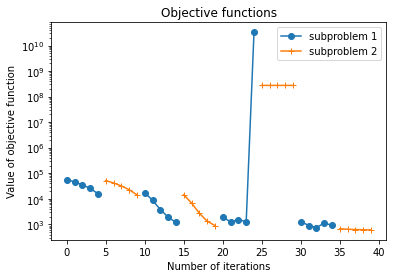

In [67]:
plt.figure()
plt.plot(obj1_val_it, 'o-', label='subproblem 1')
plt.plot(obj2_val_it, '+-', label='subproblem 2')
plt.xlabel('Number of iterations')
plt.ylabel('Value of objective function')
plt.title('Objective functions')
plt.legend()

# Logarithmic y-axis
plt.yscale('log')

Finally, let's have a look at how the images changed throughout the reconstruction

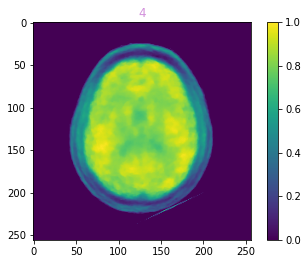

In [64]:
pio.renderers.default = 'iframe_connected'
plt.ioff()
# choose which subproblem to display
subprob = 1

fig, ax = plt.subplots()
arrays = []
ims = []
for i, image in enumerate(images):
    array = numpy.squeeze(image[subprob].as_array())
    arrays.append(array)
    im = ax.imshow(array, animated = True, vmin=0, vmax=fdg_arr.max())
    im.set_clim(0,array.max())
    title = plt.text(0.5,1.01,str(i), ha="center",va="bottom",color=numpy.random.rand(3),
                     transform=ax.transAxes, fontsize="large")
    if i == 0:
        ax.imshow(array)
        fig.colorbar(im, ax=ax)
    ims.append([im,title,])

ani = animation.ArtistAnimation(fig, ims, interval = 750, blit = True, repeat_delay = 1000)
HTML(ani.to_jshtml())

In [65]:
#%% delete temporary files
wdpath = os.getcwd()
for filename in glob.glob(os.path.join(wdpath, "tmp*")):
    os.remove(filename) 

# Next steps

The above is a good demonstration for a synergistic image reconstruction of two different images. The following gives a few suggestions of what to do next and also how to extend this notebook to other applications.

## Number of iterations
In our problem we have several regularisation parameters such as $\alpha_{1}$, $\alpha_{2}$ and $\lambda$. In addition, the number of inner iterations for each subproblem (currently set to 3) and the number of outer iterations (currently set to 10) also determine the final solution. Of course, for infinite number of total iterations it shouldn't matter but usually we don't have that much time.

__TODO__: Change the number of iterations and see what happens to the objective functions. For a given number of total iterations, do you think it is better to have a high number of inner or high number of outer iterations? Why? Does this also depend on the undersampling factor?

## Spatial misalignment
In the above example we simulated our data such that there is a perfect spatial match between $u$ and $v$. For real world applications this usually cannot be assumed. 

__TODO__: Add spatial misalignment between $u$ and $v$. This can be achieved e.g. by calling `numpy.roll` on `amyl_arr` before calling `v_gt = crop_and_fill(im_mr, amyl_arr)`. What is the effect on the reconstructed images? For a more "advanced" misalignment, have a look at notebook `BrainWeb`.

__TODO__: One way to minimize spatial misalignment is to use image registration to ensure both $u$ and $v$ are well aligned. In the notebook `sirf_registration` you find information about how to register two images and also how to resample one image based on the spatial transformation estimated from the registration. Try to use this to correct for the misalignment you introduced above. For a real world example, at which point in the code would you have to carry out the registration+resampling? (some more information can also be found at the end of [MAPEM_Bowsher notebook](MAPEM_Bowsher.ipynb))

## Pathologies
The images $u$ and $v$ show the same anatomy, just with a different distributions. Clinically more useful are of course images which show complementary image information.

__TODO__: Add a pathology to either $u$ and $v$ and see how this effects the reconstruction. For something more advanced, have a loot at the notebook `BrainWeb`.

## Single anatomical prior
So far we have alternated between two reconstruction problems. Another option is to do a single regularised reconstruction and simply use a previously reconstructed image for regularisation.

__TODO__: Adapt the above code such that $u$ is reconstructed first without regularisation and is then used for a regularised reconstruction of $v$ without any further updates of $u$.

## Other regularisation options
In this example we used a TV-based regularisation, but of course other regularisers could also be used, such as directional TV.

__TODO__: Have a look at the __CIL__ notebook `02_Dynamic_CT` and adapt the `SmoothJointTV` class above to use directional TV. 

## Other optimisation algorithms
In this example we used a Gradient Descent for ease of understanding, but other optimisation algorithms will be more appropriate and more efficient.

__TODO__: Have a look at the __CIL__ Documentaion and see if you can implement other algorithms such as PDHG or ADMM. 